In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, add

import tensorflow.keras.backend as K

2023-07-08 19:29:32.368340: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
model = VGG16()

model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

print(model.summary())

In [3]:
features = {}
directory = "flickr30k_images/flickr30k_images/"

for img_name in tqdm(os.listdir(directory)):

    if img_name == "flickr30k_images":
        pass
    
    #Load image from file
    img_path = directory + "/" + img_name
    image = load_img(img_path, target_size=(224,224))
    #convert image to np.array
    image = img_to_array(image)
    #reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #preprocess for vgg
    image = preprocess_input(image)
    #feature extraction
    feature = model.predict(image, verbose=0)
    #get image ID
    image_id = img_name.split(".")[0]
    #store feature
    features[image_id] = feature

  0%|          | 0/31783 [00:00<?, ?it/s]

2023-07-08 10:55:35.422393: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2023-07-08 10:55:37.488068: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [4]:
#store features in pickle
pickle.dump(features, open("features.pkl", "wb"))

In [ ]:
#load features from pickle
with open("features.pkl", "rb") as f:
    features = pickle.load(f)

In [ ]:
with open("flickr30k_images/results.csv", "r") as f:
    next(f)
    captions_doc = f.read()
    

In [ ]:
mapping = {}

for line in tqdm(captions_doc.split("\n")):

    tokens = line.split("|")
    if len(line) <2:
        continue
        
    image_id, caption = tokens[0], tokens[2:]

    image_id = image_id.split(".")[0]

    caption = "".join(caption[0][1:])
    
    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(caption)

    



  0%|          | 0/158916 [00:00<?, ?it/s]

In [ ]:
mapping["1000092795"]

['Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 'Two young , White males are outside near many bushes .',
 'Two men in green shirts are standing in a yard .',
 'A man in a blue shirt standing in a garden .',
 'Two friends enjoy time spent together .']

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            #remove special characters
            caption = caption.replace('[^A-Za-z]', '')
            #remove multiple spaces
            caption = caption.replace('\s+', ' ')

            caption = "startseq " + " ".join([word for word in caption.split() if len(word)>1]) + " endseq"
            captions[i] = caption


In [8]:
mapping["1000092795"]

['Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 'Two young , White males are outside near many bushes .',
 'Two men in green shirts are standing in a yard .',
 'A man in a blue shirt standing in a garden .',
 'Two friends enjoy time spent together .']

In [9]:
clean(mapping)

In [10]:
mapping["1000092795"]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [11]:
mapping["7444421214"]

['startseq there is small child that is on red and yellow swing laughing and smiling endseq',
 'startseq year old boy swings in the backyard endseq',
 'startseq child having pleasant time in swing endseq',
 'startseq young child laughing on child swing endseq',
 'startseq little boy is sitting in swing endseq']

In [12]:
all_captions = []

for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        

In [13]:
len(all_captions)

158915

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1


In [15]:
vocab_size

18313

In [16]:
#get maximum length of caption available
max_length = max(len(caption.split()) for caption in all_captions)

In [17]:
max_length

74

TRAIN TEST SPLIT

In [18]:
image_ids = list(mapping.keys())
split1 = int(len(image_ids) * 0.9)
split2 = int(len(image_ids) * 0.95)
train = image_ids[:split1]
val = image_ids[split1:split2]
test = image_ids[split2:]


DATA GENERATOR FUNCTION

In [19]:
#create data generator to get data in batch (avoids session crash)

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images 
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                #split the sequence to x and y
                for i in range(1, len(seq)):
                    #split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    #pad input_seq
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    #encode output seq
                    #out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    

                    #store sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0 


Model Creation

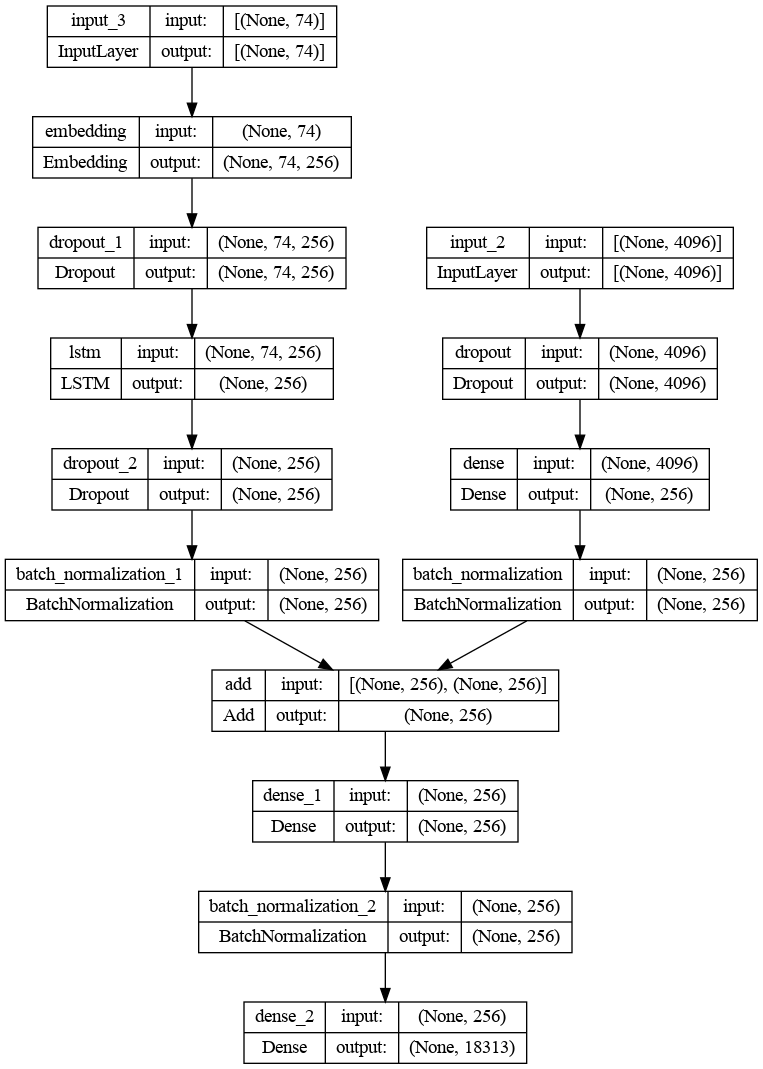

In [20]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
#Encoder model

#Image feature layers

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation="relu")(fe1)
fe2 = BatchNormalization()(fe2)

#Sequence feature layers

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
se4 = Dropout(0.4)(se3)
se5 = BatchNormalization()(se4)

#decoder Model

decoder1 = add([fe2,se5])
decoder2 = Dense(256, activation="relu")(decoder1)
decoder2 = BatchNormalization()(decoder2)
outputs = Dense(vocab_size, activation="softmax")(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)

model.compile(loss = SparseCategoricalCrossentropy(), optimizer="adam")

plot_model(model, show_shapes=True)


In [21]:
model.load_weights("model_epoch_33.h5")

Train Model

In [26]:
# Define the learning rate schedule function
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch < 30:
        print("Not Changing LR, LR is : ", lr)
        return lr  # Keep the initial learning rate for the first 10 epochs
    elif 30<=epoch< 80:
        print("LR Changed To: ", lr * 0.5)
        return lr * 0.5  # Decrease the learning rate by a factor of 0.1 after 10 epochs
    else:
        print("LR Changed To: ", lr * 0.5 * 0.5)
        return lr * 0.5 * 0.5  # Decrease the learning rate by a factor of 0.1 after 10 epochs



In [22]:
history = []  # Empty list to store the training history
i = 0

In [53]:
epochs = 120
batch_size = 64
save_frequency=3
steps = len(train) // (batch_size * 2)
learning_rate = 0.001

# Create data generator for the first half of the data
train_generator_1 = data_generator(train[:len(train) // 2], mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Create data generator for the second half of the data
train_generator_2 = data_generator(train[len(train) // 2:], mapping, features, tokenizer, max_length, vocab_size, batch_size)

val_generator = data_generator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size)


while i <= epochs:

    # Create the LearningRateScheduler callback
    lr_scheduler = LearningRateScheduler(lambda epoch: lr_schedule(i, learning_rate))

    print("EPOCH NUMBER =", i, "First Half of Data")
    # Fit for one epoch on the first half of the data
    history_1 = model.fit(train_generator_1, epochs=1, steps_per_epoch=steps,validation_freq=2, validation_data=val_generator, verbose=1,callbacks=[lr_scheduler])
    history.append(history_1)

    print("EPOCH NUMBER =", i, "Second Half of Data")
    # Fit for one epoch on the second half of the data
    history_2 = model.fit(train_generator_2, epochs=1, steps_per_epoch=steps,validation_freq=2, validation_data=val_generator, verbose=1, callbacks=[lr_scheduler])
    history.append(history_2)

    # Clear memory
    K.clear_session()
    
    if (i+1) % save_frequency == 0:
        model_name = f"model_epoch_{i+1}.h5"
        model.save(model_name)
        print(f"Saved model at epoch {i + 1} as {model_name}")

    i += 1

    


EPOCH NUMBER = 33 First Half of Data
LR Changed To:  0.0005
  2/223 [..............................] - ETA: 55s - loss: 2.5451 

2023-07-08 15:48:40.549980: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 276.92MiB (rounded to 290373632)requested by op gradients/cond_grad/If/else/_1/gradients/cond_grad/gradients/cond/transpose_grad/transpose
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-07-08 15:48:40.550035: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2023-07-08 15:48:40.550040: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 1501, Chunks in use: 1499. 375.2KiB allocated for chunks. 374.8KiB in use in bin. 11.8KiB client-requested in use in bin.
2023-07-08 15:48:40.550043: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 4, Chunks in use: 4. 2.2KiB allocated for chunks. 2.2Ki

ResourceExhaustedError: Graph execution error:

Detected at node 'gradients/cond_grad/gradients/cond/transpose_grad/transpose' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/alireza/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/alireza/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/alireza/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/alireza/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/alireza/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/alireza/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/alireza/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/alireza/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/alireza/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/alireza/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/alireza/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/alireza/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/alireza/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/alireza/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/alireza/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/alireza/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_5375/2897829724.py", line 23, in <module>
      history_1 = model.fit(train_generator_1, epochs=1, steps_per_epoch=steps,validation_freq=2, validation_data=val_generator, verbose=1,callbacks=[lr_scheduler])
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/layers/rnn/base_rnn.py", line 515, in __call__
      return super(RNN, self).__call__(inputs, **kwargs)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 673, in call
      runtime) = lstm_with_backend_selection(**normal_lstm_kwargs)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 1184, in lstm_with_backend_selection
      gru_lstm_utils.function_register(defun_gpu_lstm, **params)
    File "/home/alireza/.local/lib/python3.10/site-packages/keras/layers/rnn/gru_lstm_utils.py", line 246, in function_register
      concrete_func.add_gradient_functions_to_graph()
Node: 'gradients/cond_grad/gradients/cond/transpose_grad/transpose'
OOM when allocating tensor with shape[3832,74,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradients/cond_grad/gradients/cond/transpose_grad/transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[Adam/gradients/PartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_8600]

Generate captioons for the image 

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
# generate caption for an image:

def predict_caption(model, image, tokenizer, max_length):
    in_text = "startseq"
    #iterate over max length of sequence:
    for i in range(max_length):
        #encode input sequence:
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #pad the sequence:
        sequence = pad_sequences([sequence], max_length)
        #predict
        yhat = model.predict([image, sequence], verbose=0)
        #get index with high prob :
        yhat = np.argmax(yhat)
        #convert index to word
        word = idx_to_word(yhat, tokenizer)
        #stop if word not found
        if word is None:
            break

        #append word as input for generating next word
        in_text += " " + word
        #stop if we reach end:
        if word == "endseq":
            break

    return in_text

In [40]:
from nltk.translate.bleu_score import corpus_bleu

# validate with test data

actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption:
    captions = mapping[key]
    # predict the caption for image:
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    #split into words
    y_pred = y_pred.split()
    actual_captions = [caption.split() for caption in captions]
    #append to list
    actual.append(actual_captions)
    predicted.append(y_pred)

#calculate blue score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights = (1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights = (1.0, 0, 0, 0)))

  0%|          | 0/1590 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [54]:
pickle.dump(tokenizer, open("tokenizer.pkl", "wb"))

In [38]:
predict_caption(model, features["8217001488"], tokenizer, max_length)

'startseq man with brown hair and brown shirt is holding rifle endseq'

In [32]:
actual_captions[0]

['startseq',
 'woman',
 'with',
 'red',
 'shirt',
 'and',
 'blue',
 'boots',
 'wearing',
 'plastic',
 'bag',
 'to',
 'protect',
 'her',
 'from',
 'the',
 'rain',
 'glances',
 'down',
 'at',
 'her',
 'bundle',
 'of',
 'bok',
 'choi',
 'vegetables',
 'endseq']

In [50]:
vgg_model = VGG16()
vgg_model = Model(inputs = vgg_model.inputs, outputs = vgg_model.layers[-2].output)


In [51]:
#Load image from file
img_path = "/home/alireza/Desktop/test.jpg"
image = load_img(img_path, target_size=(224,224))
#convert image to np.array
image = img_to_array(image)
#reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#preprocess for vgg
image = preprocess_input(image)
#feature extraction
feature_test = vgg_model.predict(image, verbose=0)


In [52]:
predict_caption(model, feature_test, tokenizer, max_length)

'startseq motorcycle rider is driving down the road endseq'

In [2]:
from transformers import TFBertModel, BertTokenizer

2023-07-08 00:17:28.917362: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
